<a href="https://colab.research.google.com/github/aurioldegbelo/sis2025/blob/main/2025_SIS_Demo_4_Agents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Topics: Agents for Spatial Information Search

*  Preparatory Work (Part 1)

*  LangGraph Single Agent (Part 2)


# Part 1: Preparatory Work

## Langsmith

In [1]:
!pip install -qU langsmith

In [2]:
import os

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com/"
os.environ["LANGSMITH_API_KEY"] = "yourLangSmithKey"

In [3]:
import os
import getpass

if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")

Enter your OpenAI API key: ··········


## Database indexing

In [ ]:
!pip install -qU langchain_openai langchain-neo4j langchain_community langchain-core langchain

In [ ]:
# https://neo4j.com/developer-blog/knowledge-graph-rag-application/
# https://github.com/tomasonjo/blogs/blob/master/llm/devops_rag.ipynb
from langchain_neo4j import Neo4jGraph

url = "YourUrl"
username = "neo4j"
password = "YourPassword"

In [68]:
# create the index
import os
from langchain_neo4j import Neo4jVector
from langchain_openai import OpenAIEmbeddings


# indexing beyond a single node, see https://stackoverflow.com/a/78241152
retrieval_query = """
       MATCH (node)-[:HAS_GEOMETRY]->(g:Geometry)
       WITH node, score, collect(g) as geom
       RETURN node.name as text, score, node{.*, embedding: Null, geometries: geom} as metadata
       """

custom_vector_index = Neo4jVector.from_existing_index(
    embedding=OpenAIEmbeddings(),
    url=url,
    username=username,
    password=password,
    index_name='index_for_state',
    node_label="State",
    text_node_property="name",
    retrieval_query=retrieval_query
)


'''
# indexing for a single node
custom_vector_index = Neo4jVector.from_existing_graph(
    OpenAIEmbeddings(),
    url=url,
    username=username,
    password=password,
    index_name='index_for_state',
    node_label="State",
    text_node_properties= ['name', 'population', 'state_capital', 'area'], # properties of the nodes containing the textual data from which embeddings will be generated.
    embedding_node_property='embedding' # The property name where the embeddings will be stored in the database.
)
'''


'\n# indexing for a single node\ncustom_vector_index = Neo4jVector.from_existing_graph(\n    OpenAIEmbeddings(),\n    url=url,\n    username=username,\n    password=password,\n    index_name=\'index_for_state\',\n    node_label="State",\n    text_node_properties= [\'name\', \'population\', \'state_capital\', \'area\'], # properties of the nodes containing the textual data from which embeddings will be generated.\n    embedding_node_property=\'embedding\' # The property name where the embeddings will be stored in the database.\n)\n'

In [69]:
# see the index just created
custom_vector_index.query(
    """SHOW INDEXES
       YIELD name, type, labelsOrTypes, properties, options
       WHERE type = 'VECTOR'
    """
)

[{'name': 'index_for_state',
  'type': 'VECTOR',
  'labelsOrTypes': ['State'],
  'properties': ['embedding'],
  'options': {'indexConfig': {'vector.dimensions': 1536,
    'vector.hnsw.m': 16,
    'vector.quantization.enabled': True,
    'vector.similarity_function': 'COSINE',
    'vector.hnsw.ef_construction': 100},
   'indexProvider': 'vector-3.0'}}]

# Part 2: Agent

In [8]:
!pip -q install langgraph langchain-tavily pyowm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 17.3 MB/s eta 0:00:00


In [9]:
import os
from typing import TypedDict, List, Dict, Any, Optional
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI

## Step 1: Define our state class


In [10]:
from langchain_core.documents import Document

# Example adapted from https://huggingface.co/learn/agents-course/unit2/langgraph/first_graph
class AgentState(TypedDict):

    action: Dict[str, Any]

    docs: List[Document]

    reranked_results: List[Document]

    query: str

    vector_index: Neo4jVector

## Step 2: Define our tools/custom functions

In [11]:
if "TAVILY_API_KEY" not in os.environ:
    os.environ["TAVILY_API_KEY"] = getpass.getpass("Enter your TavilySearch API key: ")

Enter your TavilySearch API key: ··········


In [12]:
os.environ["OPENWEATHERMAP_API_KEY"] = "your-open-weather_key"

In [60]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_tavily import TavilySearch
from langchain_community.utilities import OpenWeatherMapAPIWrapper
from langchain_core.runnables import RunnableLambda


# ROUTING LOGIC - interpreting the input to decide on an path
# Because a node must return a dictionary in langgraph at the moment, we define this function to do the interpretation only
# The next function assigns an action to
def query_interpreter(state: AgentState):
    """Determine the type of query"""

    query = state['query']

    template = """
    You are a specialised agent that selects one of three actions based on the given context:

    For the given context return
    weather: if the query is about weather
    rag: if the query is about geometries
    search: if the query is about searching the web

    Only return one of these three options and nothing else. Return "search" if you are unsure.

    Context: {context}
    """
    llm1 = ChatOpenAI(model="gpt-4o-mini")
    routing_prompt = ChatPromptTemplate.from_template(template)
    routing_llm = routing_prompt | llm1
    print("The query is...", query)
    action = routing_llm.invoke({"context": query})
    print("action interpreted:", action.content)

    return {"action": action.content, "vector_index": custom_vector_index}

# decide on which action to do, based on the information extracted from the query
def select_action(state: AgentState):
    action = state['action']
    if action == "weather":
        return "api_action"
    elif action == "rag":
        return "rag_action"
    else: return "search_action"

# call a search engine
def search_engine_call(state: AgentState):
  print("...doing search on the Web...")
  query = state['query']
  search_engine = TavilySearch(max_results=5) # see https://docs.langchain.com/oss/python/integrations/tools/tavily_search
  resp = search_engine.invoke({"query": query})
  print(resp['results'])

# call the open weather map api
def api_call(state: AgentState):
  # https://docs.langchain.com/oss/python/integrations/providers/openweathermap
  print("...doing an API call to get the current weather...")
  location = "Münster, Germany"
  weather = OpenWeatherMapAPIWrapper()
  weather_data = weather.run(location)
  print(weather_data)

# retrieve most relevant documents from the neo4j database, along with their scores
def rag_retrieve(state: AgentState):
  print("...retrieving from the custom database...")
  query = state['query']
  response_with_score = custom_vector_index.similarity_search_with_score(query)
  print(response_with_score)
  return {"docs": response_with_score}

# rerank the results
def rerank_results(state: AgentState):
  print("... reranking the results...")
  docs = state['docs']

  for doc in docs:
       doc[0].metadata["old_score"] = doc[1]
       doc[0].metadata["new_score"] = -50 * doc[1] #* -10
  return {"reranked_results": docs}

# verbalize the results
def verbalize_results(state: AgentState):
  print("... transforming the results into nice text...")

  template = """Answer the question based only on the following context:
  {context}
  Compile a final answer to the user's question.
  Also provide, as a supporting information, a sorting of the input documents according to the new scores.
  Question: {question}
  """

  prompt = ChatPromptTemplate.from_template(template)
  llm2 = ChatOpenAI(model_name="gpt-4o", temperature=0) # gpt-3.5-turbo
  graph_chain = prompt | llm2 | StrOutputParser()

  reranked_results = state['reranked_results']
  user_question = state['query']

  final_answer = graph_chain.invoke({"context": reranked_results, "question": user_question})
  print("----------------")
  print("FINAL ANSWER", final_answer)
  print("----------------")

## Step 3: Define our workflow

In [62]:
# Create the graph
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("interpret_query", query_interpreter)
workflow.add_node("use_search_engine", search_engine_call)
workflow.add_node("call_api", api_call)
workflow.add_node("use_rag_retrieve", rag_retrieve)
workflow.add_node("use_rag_rerank", rerank_results)
workflow.add_node("verbalize_results", verbalize_results)

# Start the edges
workflow.add_edge(START, "interpret_query")

# Add conditional branching
workflow.add_conditional_edges(
    "interpret_query",
    select_action,
    {
        "search_action": "use_search_engine",
        "rag_action": "use_rag_retrieve",
        "api_action": "call_api"
    }
)

# Add additional edges to define the flow
workflow.add_edge("use_search_engine", END)
workflow.add_edge("call_api", END)
workflow.add_edge("use_rag_retrieve", "use_rag_rerank")
workflow.add_edge("use_rag_rerank", "verbalize_results")
workflow.add_edge("verbalize_results", END)

# Compile the graph
compiled_graph = workflow.compile()

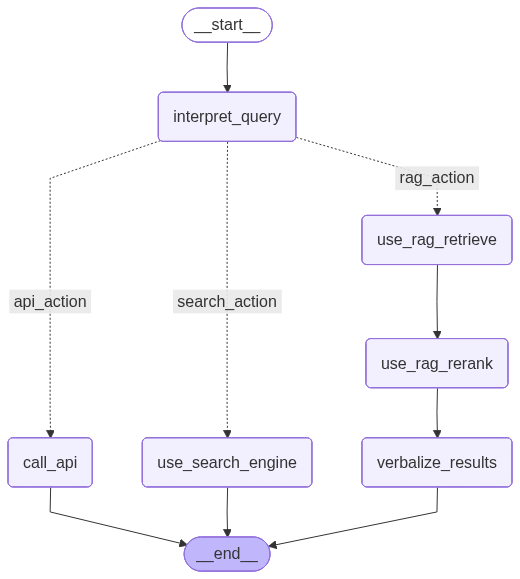

In [57]:
from IPython.display import Image, display, Audio

try:
    display(Image(compiled_graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [63]:
question1 = "How many states in the database?"
question2 = "How many geometries in the the database?"
question3 = "What is the population of Hessen?"
question4 = "What is the area of Niedersachsen?"
question5 = "What is the capital of Rheinland-Pfalz?"
question6 = "What is the geometry of Nordrhein-Westfalen?"
question7 = "What are the geometries of Hessen and Niedersachsen?"
question8 = "What is the url of the geometry of Hessen?"

question9 = "What is the institute for geoinformatics?"
question10 = "What is the weather in Münster like?"

In [70]:
compiled_graph.invoke({"query": question8})

The query is... What is the url of the geometry of Hessen?
action interpreted: rag
...retrieving from the custom database...
[(Document(metadata={'state_capital': 'Wiesbaden', 'area': 21114.94, 'geometries': [{'url': 'https://github.com/aurioldegbelo/sis2025/blob/main/vector_data/hessen.geojson'}], 'name': 'Hessen', 'population': 6391360}, page_content='Hessen'), 0.9082183837890625), (Document(metadata={'state_capital': 'Hannover', 'area': 47709.82, 'geometries': [{'url': 'https://github.com/aurioldegbelo/sis2025/blob/main/vector_data/niedersachsen.geojson'}], 'name': 'Niedersachsen', 'population': 8140242}, page_content='Niedersachsen'), 0.8850250244140625), (Document(metadata={'state_capital': 'Mainz', 'area': 19854.21, 'geometries': [{'url': 'https://github.com/aurioldegbelo/sis2025/blob/main/vector_data/rheinland-pfalz.geojson'}], 'name': 'Rheinland-Pfalz', 'population': 4159150}, page_content='Rheinland-Pfalz'), 0.8829345703125), (Document(metadata={'state_capital': 'Düsseldorf', 

{'query': 'What is the url of the geometry of Hessen?',
 'docs': [(Document(metadata={'state_capital': 'Wiesbaden', 'area': 21114.94, 'geometries': [{'url': 'https://github.com/aurioldegbelo/sis2025/blob/main/vector_data/hessen.geojson'}], 'name': 'Hessen', 'population': 6391360, 'old_score': 0.9082183837890625, 'new_score': -45.410919189453125}, page_content='Hessen'),
   0.9082183837890625),
  (Document(metadata={'state_capital': 'Hannover', 'area': 47709.82, 'geometries': [{'url': 'https://github.com/aurioldegbelo/sis2025/blob/main/vector_data/niedersachsen.geojson'}], 'name': 'Niedersachsen', 'population': 8140242, 'old_score': 0.8850250244140625, 'new_score': -44.251251220703125}, page_content='Niedersachsen'),
   0.8850250244140625),
  (Document(metadata={'state_capital': 'Mainz', 'area': 19854.21, 'geometries': [{'url': 'https://github.com/aurioldegbelo/sis2025/blob/main/vector_data/rheinland-pfalz.geojson'}], 'name': 'Rheinland-Pfalz', 'population': 4159150, 'old_score': 0.8829

# Project Work

* Exercice 01: Go through the [Langgraph tutorial](https://docs.langchain.com/oss/python/langgraph/quickstart). It covers basics such as node, edges, states/state customization and memory addition

* Exercice 02: Think about and draft a first version of the architecture for your project scenario on a piece of paper (agent, their components, their connections).

The notebook has only scratched the surface of Langgraph and more functionalities can be found in the [Langgraph documentation](https://langchain-ai.github.io/langgraph/tutorials/introduction/).

Happy coding!